In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

os.chdir('/content/drive/MyDrive/datasets/archive')
!ls

best_model.keras  seg_pred  seg_test  seg_train


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (
    Activation,
    BatchNormalization,
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    MaxPooling2D
)

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, TensorBoard

In [ ]:
from tensorflow.keras import mixed_precision

policy = mixed_precision.Policy("float32")
mixed_precision.set_global_policy(policy)

### GPU

In [ ]:
gpus = tf.config.experimental.list_physical_devices("GPU")

if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            print(gpu)

    except RuntimeError as e:
        print(e)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


### Loading the images

In [ ]:
train_path = 'seg_train/seg_train/'
test_path = 'seg_test/seg_test/'
prediction_path = 'seg_pred/seg_pred/'

In [ ]:
import glob as gb

for folder in os.listdir(train_path):
    files = gb.glob(pathname=str(train_path) + folder + "/*.jpg")
    print(f"for training data, found {len(files)} in folder {folder}")

for training data, found 2271 in folder forest
for training data, found 2512 in folder mountain
for training data, found 2191 in folder buildings
for training data, found 2404 in folder glacier
for training data, found 2382 in folder street
for training data, found 2274 in folder sea


In [ ]:
for folder in os.listdir(test_path):
    files = gb.glob(pathname=str(test_path) + folder + "/*.jpg")
    print(f"for test data, found {len(files)} in folder {folder}")

for test data, found 437 in folder buildings
for test data, found 474 in folder forest
for test data, found 501 in folder street
for test data, found 525 in folder mountain
for test data, found 553 in folder glacier
for test data, found 510 in folder sea


In [ ]:
files = gb.glob(pathname=str(prediction_path) + "/*.jpg")
print(f"for training data, found {len(files)}")

for training data, found 7301


## Constants

In [ ]:
encode = {
    "buildings": 0,
    "forest": 1,
    "glacier": 2,
    "mountain": 3,
    "sea": 4,
    "street": 5,
}

IMG_SIZE = (150, 150)
n_classes = len(encode)

### HyperParameters


In [ ]:
EPOCHS = 300
BATCH_SIZE = 32
LEARNING_RATE = 0.0001
REGULARIZATION_L2 = 0.01
DROPOUT_RATE = 0.5

### Loading the images

In [ ]:
from tqdm import tqdm
import numpy as np
import cv2


def load_data(data_path: str, img_size: tuple, encode: dict, is_test: bool = False):
    images, labels = [], []

    for folder in tqdm(os.listdir(data_path), desc="Folders"):
        label = encode[folder]
        folder_path = os.path.join(data_path, folder)

        for file in tqdm(
            os.listdir(folder_path), desc=f"Files in {folder}", leave=False
        ):
            img_path = os.path.join(folder_path, file)

            img = cv2.imread(img_path)
            if img is None:
                print(f"Failed to read image: {img_path}")
                continue

            try:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, img_size)
            except cv2.error as e:
                print(f"Error processing image {img_path}: {str(e)}")
                continue

            images.append(img)
            labels.append(label)

    images = np.array(images, dtype=np.float32)
    labels = np.array(labels, dtype=np.int32)

    return images, labels

In [ ]:
X_train, y_train = load_data(train_path, IMG_SIZE, encode)
X_test, y_test = load_data(test_path, IMG_SIZE, encode)

Folders: 100%|██████████| 6/6 [00:59<00:00,  9.87s/it]


### Showing examples of images inside the dataset.

In [14]:
import matplotlib.pyplot as plt


def display_examples(images, labels):
    fig = plt.figure(figsize=(15, 15))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    x = 1
    idx = np.random.choice(images.shape[0], 30, replace=False)

    for i in idx:
        plt.subplot(5, 6, x)
        plt.xticks([])
        plt.yticks([])

        plt.grid(False)
        plt.imshow(images[i] / 255, cmap=plt.cm.binary)
        plt.xlabel(list(encode.keys())[labels[i]])

        x += 1

    plt.show()

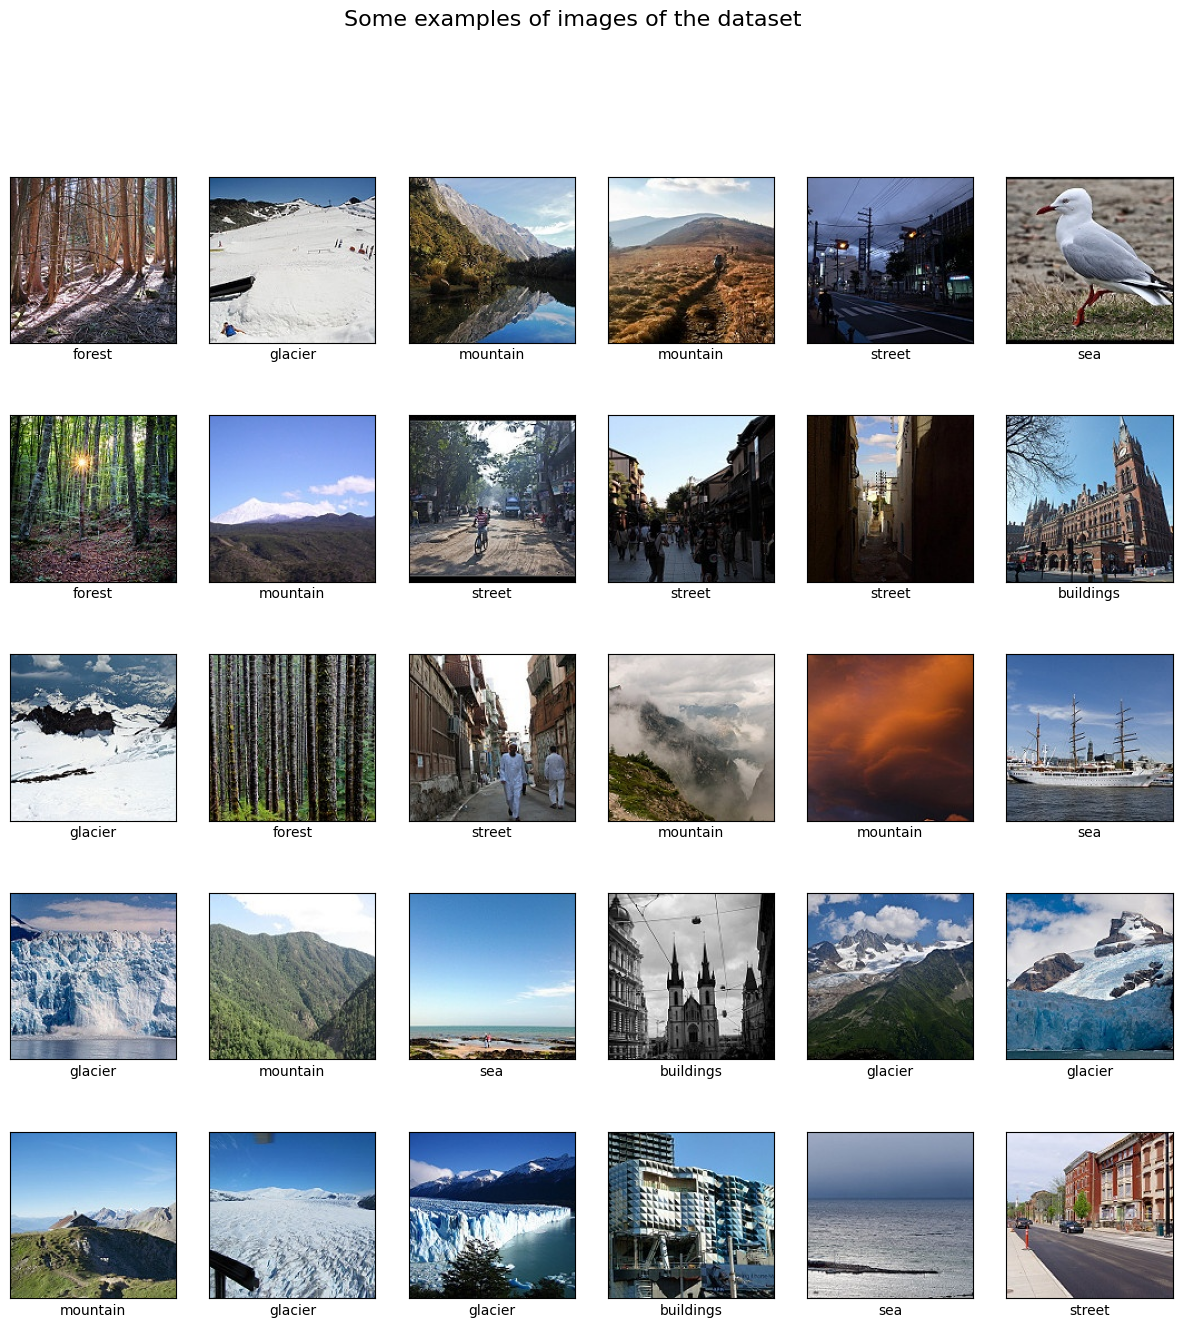

In [15]:
display_examples(X_train, y_train)

### Shuffles the training and test data

In [16]:
idx = np.random.permutation(X_train.shape[0])
X_train = X_train[idx]
y_train = y_train[idx]

iddx = np.random.permutation(X_test.shape[0])
X_test = X_test[iddx]
y_test = y_test[iddx]

### Normalization

In [17]:
X_train /= 255
X_test /= 255

### Residual CNN Model


In [24]:
from tensorflow.keras.layers import LeakyReLU, Add, Input


def residual_block(
    x,
    filters,
    kernel_size=3,
    stride=1):
    shortcut = x

    x = Conv2D(
        filters, kernel_size, stride, padding="same", kernel_regularizer=l2(REGULARIZATION_L2)
    )(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(negative_slope=0.1)(x)

    x = Conv2D(filters, kernel_size, padding="same", kernel_regularizer=l2(REGULARIZATION_L2))(x)
    x = BatchNormalization()(x)

    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = Conv2D(
            filters, 1, stride, padding="same", kernel_regularizer=l2(REGULARIZATION_L2)
        )(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = LeakyReLU(negative_slope=0.1)(x)

    return x


def create_model(input_shape=(150, 150, 3), n_classes=10):
    inputs = Input(shape=input_shape)

    x = Conv2D(32, (3, 3), padding="same", kernel_regularizer=l2(REGULARIZATION_L2))(inputs)
    x = BatchNormalization()(x)
    x = LeakyReLU(negative_slope=0.1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = residual_block(x, 64)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = residual_block(x, 128)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = residual_block(x, 256)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Flatten()(x)
    x = Dense(256, kernel_regularizer=l2(REGULARIZATION_L2))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(negative_slope=0.1)(x)
    x = Dropout(DROPOUT_RATE)(x)

    x = Flatten()(x)
    outputs = Dense(n_classes, activation="softmax")(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [53]:
model = create_model(input_shape=(150, 150, 3), n_classes=n_classes)

In [54]:
optimizers = Adam(learning_rate=LEARNING_RATE)

In [55]:
model.compile(
    optimizer=optimizers, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

In [56]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 150, 150, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 150, 150, 32)   │            896 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_22    │ (None, 150, 150, 32)   │            128 │ conv2d_23[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_16            │ (None, 150, 150, 32)   │              0 │ batch_normalization_2… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_10          │ (None, 75, 75, 32)     │              0 │ leaky_re_lu_16[0][0]   │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_24 (Conv2D)        │ (None, 75, 75, 64)     │         18,496 │ max_pooling2d_10[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_23    │ (None, 75, 75, 64)     │            256 │ conv2d_24[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_17            │ (None, 75, 75, 64)     │              0 │ batch_normalization_2… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_25 (Conv2D)        │ (None, 75, 75, 64)     │         36,928 │ leaky_re_lu_17[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_26 (Conv2D)        │ (None, 75, 75, 64)     │          2,112 │ max_pooling2d_10[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_24    │ (None, 75, 75, 64)     │            256 │ conv2d_25[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_25    │ (None, 75, 75, 64)     │            256 │ conv2d_26[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_6 (Add)               │ (None, 75, 75, 64)     │              0 │ batch_normalization_2… │
│                           │                        │                │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_18            │ (None, 75, 75, 64)     │              0 │ add_6[0][0]            │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_11     

 Total params: 6,523,206 (24.88 MB)

 Trainable params: 6,519,942 (24.87 MB)

 Non-trainable params: 3,264 (12.75 KB)

In [57]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    filepath="best_model_residuals.keras",
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1,
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss", factor=0.2, patience=5, min_lr=0.0001, verbose=1
)

In [58]:
history = model.fit(
    X_train,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    callbacks=[checkpoint, reduce_lr]
)

Epoch 1/300
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.5910 - loss: 16.0429
Epoch 1: val_accuracy improved from -inf to 0.46918, saving model to best_model_residuals.keras
351/351 ━━━━━━━━━━━━━━━━━━━━ 34s 64ms/step - accuracy: 0.5912 - loss: 16.0399 - val_accuracy: 0.4692 - val_loss: 13.7736 - learning_rate: 1.0000e-04
Epoch 2/300
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.7828 - loss: 12.1296
Epoch 2: val_accuracy improved from 0.46918 to 0.78696, saving model to best_model_residuals.keras
351/351 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.7828 - loss: 12.1273 - val_accuracy: 0.7870 - val_loss: 9.8506 - learning_rate: 1.0000e-04
Epoch 3/300
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8390 - loss: 9.1033
Epoch 3: val_accuracy did not improve from 0.78696
351/351 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step - accuracy: 0.8389 - loss: 9.1017 - val_accuracy: 0.7328 - val_loss: 7.7416 - learning_rate: 1.0000e-04
Epoch 4/300
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 

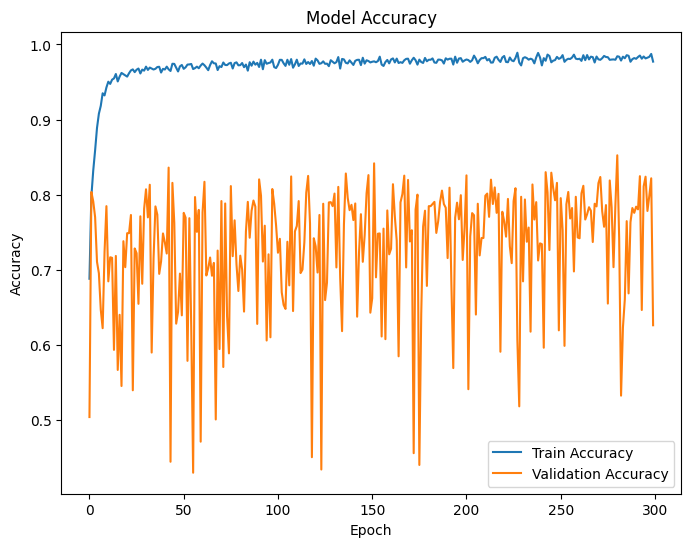

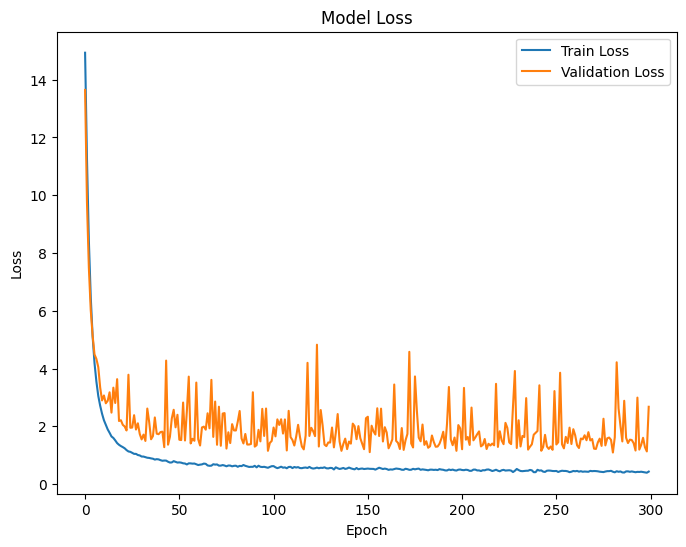

In [31]:
# Create figure for accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.show()

# Create figure for loss
plt.figure(figsize=(8, 6))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="best")
plt.show()

### Evaluating the model

In [59]:
best_model = load_model('best_model_residuals.keras')

In [60]:
test_loss, test_accuracy = best_model.evaluate(X_test, y_test, verbose=1)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.8256 - loss: 1.1052
Test Loss: 1.1141
Test Accuracy: 0.8257


In [61]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [62]:
predictions = best_model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


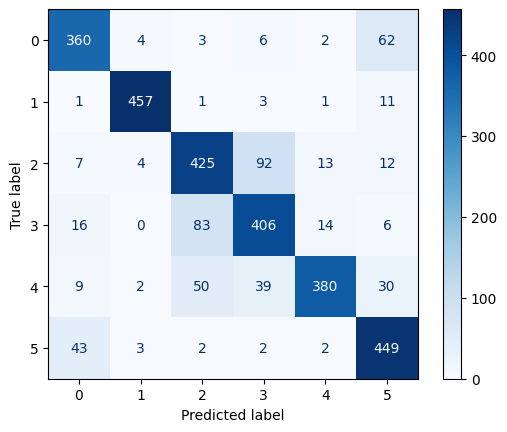

In [63]:
cm = confusion_matrix(y_test, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", colorbar=True)

### Fine Tuning

In [64]:
checkpoint = ModelCheckpoint(
    filepath="best_model_residuals.keras",
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1,
)

In [66]:
# fine-tuning
model.trainable = True

for layer in model.layers[:-5]:
    layer.trainable = False

In [67]:
model.compile(
    optimizer=optimizers, loss="sparse_categorical_crossentropy", metrics=["accuracy"],
)

In [68]:
history = model.fit(
    X_train,
    y_train,
    epochs=EPOCHS // 2,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    callbacks=[checkpoint, reduce_lr]
)

Epoch 1/150
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9753 - loss: 0.0682
Epoch 1: val_accuracy improved from -inf to 0.84467, saving model to best_model_residuals.keras
351/351 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.9753 - loss: 0.0682 - val_accuracy: 0.8447 - val_loss: 0.6719 - learning_rate: 1.0000e-04
Epoch 2/150
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9792 - loss: 0.0621
Epoch 2: val_accuracy improved from 0.84467 to 0.84646, saving model to best_model_residuals.keras
351/351 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9792 - loss: 0.0621 - val_accuracy: 0.8465 - val_loss: 0.6705 - learning_rate: 1.0000e-04
Epoch 3/150
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9787 - loss: 0.0604
Epoch 3: val_accuracy did not improve from 0.84646
351/351 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9787 - loss: 0.0604 - val_accuracy: 0.8465 - val_loss: 0.6678 - learning_rate: 1.0000e-04
Epoch 4/150
346/351 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/st

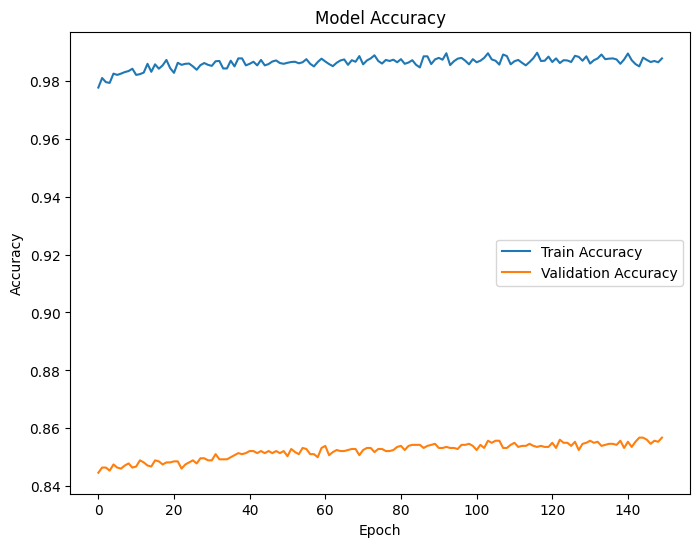

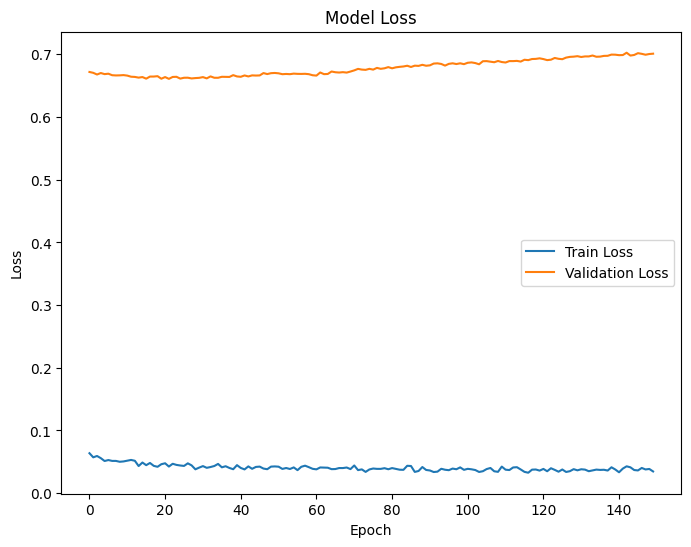

In [69]:
# Create figure for accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.show()

# Create figure for loss
plt.figure(figsize=(8, 6))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="best")
plt.show()

In [70]:
best_model = load_model('best_model_residuals.keras')

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 10 variables whereas the saved optimizer has 94 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [71]:
test_loss, test_accuracy = best_model.evaluate(X_test, y_test, verbose=1)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8325 - loss: 0.7497
Test Loss: 0.7287
Test Accuracy: 0.8373


In [72]:
predictions = best_model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


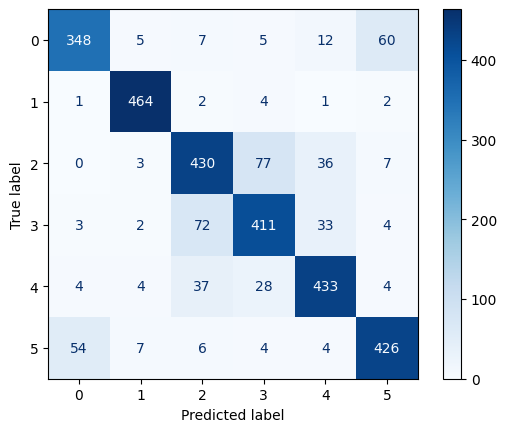

In [73]:
cm = confusion_matrix(y_test, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", colorbar=True)

### Simple CNN

In [74]:
checkpoint = ModelCheckpoint(
    filepath="best_model_simplified.keras",
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1,
)

In [75]:
def create_simplified_model(input_shape=(150, 150, 3), n_classes=6):
    model = Sequential(
        [
            Conv2D(32, (3, 3), activation="relu", input_shape=input_shape),
            MaxPooling2D((2, 2)),
            Conv2D(64, (3, 3), activation="relu"),
            MaxPooling2D((2, 2)),
            Conv2D(64, (3, 3), activation="relu"),
            Flatten(),
            Dense(64, activation="relu"),
            Dense(n_classes, activation="softmax"),
        ]
    )

    return model

In [76]:
model = create_simplified_model(input_shape=(150, 150, 3), n_classes=n_classes)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [77]:
model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

In [78]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_33 (Conv2D)                   │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_34 (Conv2D)                   │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_35 (Conv2D)                   │ (None, 34, 34, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 73984)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 64)                  │       4,735,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,791,750 (18.28 MB)

 Trainable params: 4,791,750 (18.28 MB)

 Non-trainable params: 0 (0.00 B)

In [79]:
history = model.fit(
    X_train,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    callbacks=[checkpoint, reduce_lr]
)

Epoch 1/300
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5385 - loss: 1.1678
Epoch 1: val_accuracy improved from -inf to 0.71464, saving model to best_model_simplified.keras
351/351 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.5388 - loss: 1.1672 - val_accuracy: 0.7146 - val_loss: 0.7407 - learning_rate: 0.0010
Epoch 2/300
349/351 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7811 - loss: 0.6147
Epoch 2: val_accuracy improved from 0.71464 to 0.79444, saving model to best_model_simplified.keras
351/351 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.7810 - loss: 0.6148 - val_accuracy: 0.7944 - val_loss: 0.5962 - learning_rate: 0.0010
Epoch 3/300
349/351 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8378 - loss: 0.4516
Epoch 3: val_accuracy improved from 0.79444 to 0.80834, saving model to best_model_simplified.keras
351/351 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.8378 - loss: 0.4516 - val_accuracy: 0.8083 - val_loss: 0.5689 - learning_rate: 0.0010
Epoch 4/300


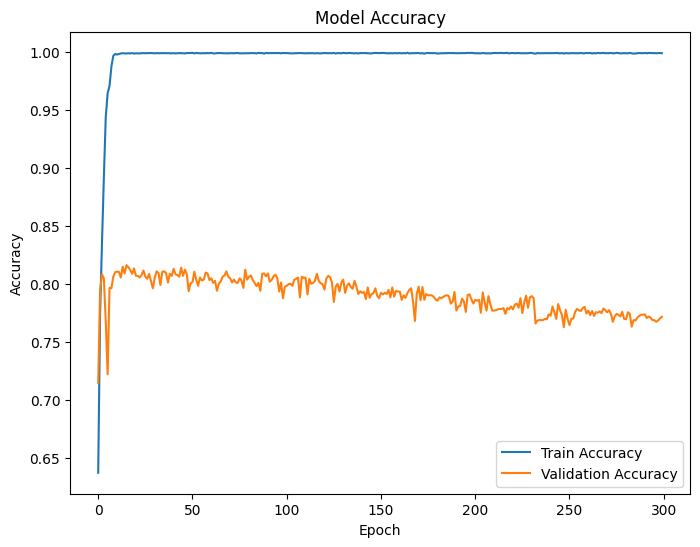

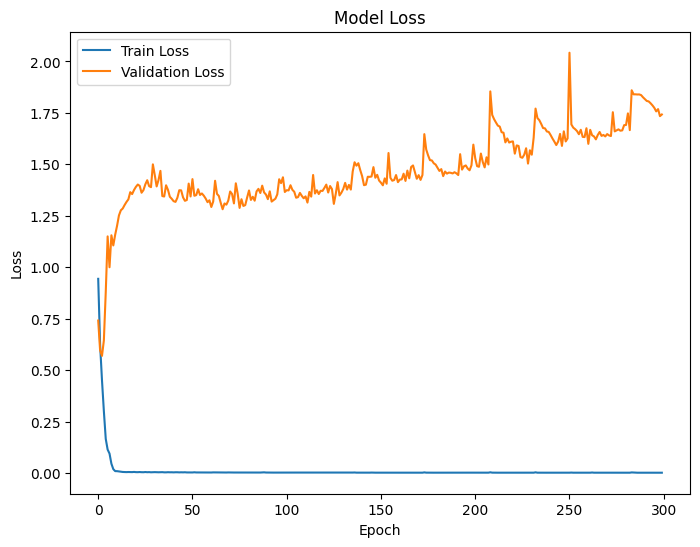

In [80]:
# Create figure for accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.show()

# Create figure for loss
plt.figure(figsize=(8, 6))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="best")
plt.show()

In [81]:
best_model = load_model('best_model_simplified.keras')

In [82]:
test_loss, test_accuracy = best_model.evaluate(X_test, y_test, verbose=1)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7985 - loss: 1.3435
Test Loss: 1.2999
Test Accuracy: 0.8003


In [83]:
predictions = best_model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


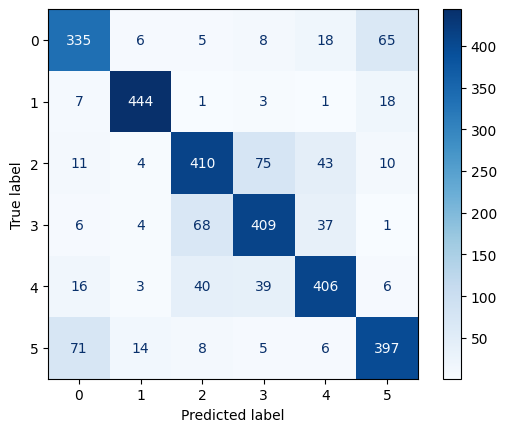

In [84]:
cm = confusion_matrix(y_test, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", colorbar=True)

## Fine Tunning


In [85]:
# fine tuning
model.trainable = True

for layer in model.layers[:-5]:
    layer.trainable = False

In [86]:
model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

In [87]:
history = model.fit(
    X_train,
    y_train,
    epochs=EPOCHS // 2,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    callbacks=[checkpoint, reduce_lr]
)

Epoch 1/150
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9970 - loss: 0.0104
Epoch 1: val_accuracy did not improve from 0.81617
351/351 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.9970 - loss: 0.0104 - val_accuracy: 0.7877 - val_loss: 2.2427 - learning_rate: 0.0010
Epoch 2/150
344/351 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9937 - loss: 0.0270
Epoch 2: val_accuracy did not improve from 0.81617
351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9937 - loss: 0.0272 - val_accuracy: 0.7606 - val_loss: 2.4828 - learning_rate: 0.0010
Epoch 3/150
349/351 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9937 - loss: 0.0340
Epoch 3: val_accuracy did not improve from 0.81617
351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9937 - loss: 0.0340 - val_accuracy: 0.7663 - val_loss: 2.4315 - learning_rate: 0.0010
Epoch 4/150
348/351 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9965 - loss: 0.0162
Epoch 4: val_accuracy did not improve from 0.81617
351/351 ━━━━━━━━━━━━━━━━

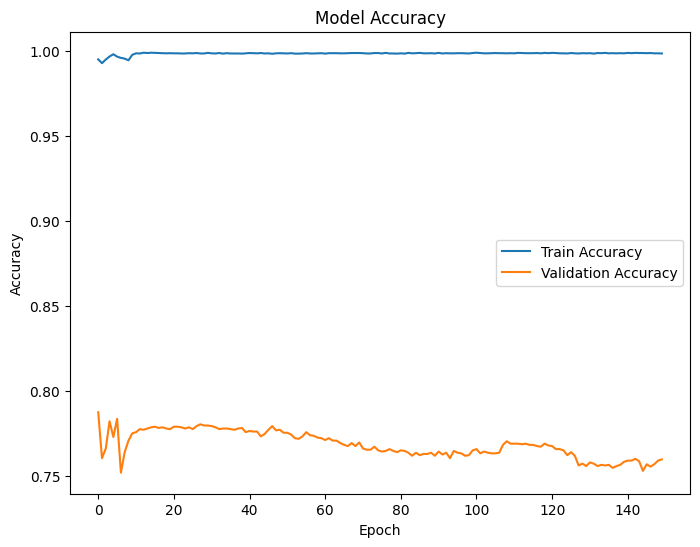

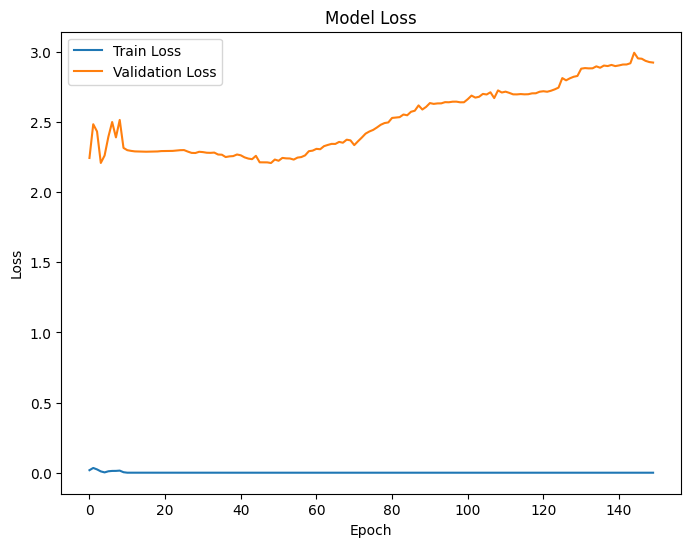

In [88]:
# Create figure for accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.show()

# Create figure for loss
plt.figure(figsize=(8, 6))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="best")
plt.show()

In [89]:
best_model = load_model('best_model_simplified.keras')

In [90]:
test_loss, test_accuracy = best_model.evaluate(X_test, y_test, verbose=1)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7985 - loss: 1.3435
Test Loss: 1.2999
Test Accuracy: 0.8003


In [91]:
predictions = best_model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


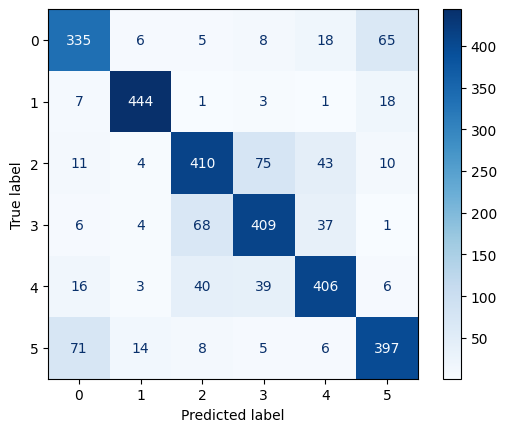

In [92]:
cm = confusion_matrix(y_test, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", colorbar=True)